In [18]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


## Data Visualization

In [3]:
data_dir = "data"
train_dir = os.path.join(data_dir , "train")
test_dir = os.path.join(data_dir , "test")

train_benign = os.path.join(train_dir,"Benign")
train_malignant = os.path.join(train_dir , "Malignant")
test_benign = os.path.join(test_dir,"Benign")
test_malignant = os.path.join(test_dir , "Malignant")

print("Number of benign in the training data:", len(os.listdir(train_benign)))
print("Number of malignant in the training data:", len(os.listdir(train_malignant)))
print("Number of benign in the testing data:", len(os.listdir(test_benign)))
print("Number of malignant in the testing data:", len(os.listdir(test_malignant)))

Number of benign in the training data: 6289
Number of malignant in the training data: 5590
Number of benign in the testing data: 1000
Number of malignant in the testing data: 1000


Benign image: (224, 224)
Malignant image: (224, 224)


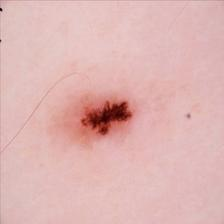

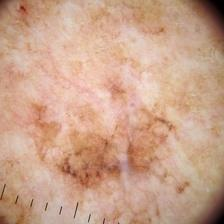

In [4]:
train_benign_path = os.path.join(train_benign, os.listdir(train_benign)[0])
benign_image = Image.open(train_benign_path)
print("Benign image:", benign_image.size)

train_malignant_path = os.path.join(train_malignant, os.listdir(train_malignant)[0])
malignant_image = Image.open(train_malignant_path)
print("Malignant image:", malignant_image.size)

display(benign_image)
display(malignant_image)

## Configs

In [14]:
configs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "epochs": 30
}

## Classification Dataset

In [28]:
train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomRotation(degrees=(-10, 10)),
    # torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1)),
    # torchvision.transforms.ColorJitter(brightness=0.1, constrast=0.1, hue=0.1),
    # torchvision.transforms.RandAugment(magnitude=7),
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4864, 0.4036, 0.3594], std=[0.3129, 0.2744, 0.2641]) 
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4864, 0.4036, 0.3594], std=[0.3129, 0.2744, 0.2641])
])

train_dataset   = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset   = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transforms

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = configs['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_dataset, 
    batch_size  = configs['batch_size'],
    shuffle     = False,
    num_workers = 2
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset, 
    batch_size  = configs['batch_size'],
    shuffle     = False,
    num_workers = 2
)

In [30]:
print("Number of classes    : ", len(test_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", configs['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches        : ", val_loader.__len__())
print("Test batches         : ", test_loader.__len__())

Number of classes    :  2
No. of train images  :  9503
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  149
Val batches        :  38
Test batches         :  32


## Simple CNN

In [42]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*56*56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(test_dataset.classes))

In [43]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=configs['learning_rate'])

In [39]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

    acc         = 100 * num_correct / (configs['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [40]:
def validate(model, dataloader, criterion):
    model.eval()
    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

    acc = 100 * num_correct / (configs['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [44]:
for epoch in range(configs['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        configs['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss = validate(model, val_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))


Epoch 1/30: 
Train Acc 75.1049%	 Train Loss 1.2341	 Learning Rate 0.0010
Val Acc 81.0033%	 Val Loss 0.6247

Epoch 2/30: 
Train Acc 85.4656%	 Train Loss 0.6187	 Learning Rate 0.0010
Val Acc 83.5938%	 Val Loss 0.6156


KeyboardInterrupt: 

In [61]:
def test(model,dataloader):

  model.eval()
  pred_labels = []
  true_labels = []
  
  for i, (images, labels) in enumerate(dataloader):
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      pred_labels.extend(outputs)
      true_labels.extend(labels.cpu().numpy().tolist())
      
  return pred_labels, true_labels

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


pred_labels, true_labels = test(model, test_loader)
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels,)
recall = recall_score(true_labels, pred_labels,)
f1 = f1_score(true_labels, pred_labels,)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## Post processing

- Hyperparameter tuning

- Ensemble methods

- Threshold adjustment

- Feature extraction